In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
print("Class folders:", len([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]))
print("Metadata exists:", os.path.exists(os.path.join(dataset_dir, "metadata.csv")))
print("Split CSV exists:", os.path.exists(os.path.join(dataset_dir, "dataset_split.csv")))

Class folders: 44
Metadata exists: True
Split CSV exists: True


In [2]:
!pip install transformers datasets torch pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [2]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
print("Transformers installed successfully!")

Transformers installed successfully!


In [2]:
file_path = "/kaggle/input/heritage-data-set/heritage_dataset/Doddabasappa_Temple_Gadag/Doddabasappa_Temple_Gadag_035.jpg"
print("File exists:", os.path.exists(file_path))

File exists: True


In [3]:
import pandas as pd
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"
df = pd.read_csv(split_csv)
print("Sample image paths:")
print(df["image_path"].head())
print("Unique classes:", df["class_name"].nunique())
print("Class counts:", df["class_name"].value_counts())

Sample image paths:
0    Twin_Tower_Temple_Sudi\Twin_Tower_Temple_Sudi_...
1    Hoysaleshwara_Temple_Halebeedu\Hoysaleshwara_T...
2    Brahmeshwar_Temple_Kikkeri\Brahmeshwar_Temple_...
3    Chennakeshwara_Temple_Belur\Chennakeshwara_Tem...
4    Hoysaleshwara_Temple_Halebeedu\Hoysaleshwara_T...
Name: image_path, dtype: object
Unique classes: 44
Class counts: class_name
Channakeshwa_Temple_Aralguppe          66
Monolithic_Bull_Hampi                  61
Billeshwar_Temple_Hanagal              61
Twin_Tower_Temple_Sudi                 60
Lakshmikant_Temple_Nanjangudu          60
Mahadeva_Temple_Ittagi                 60
Safa_Masjid__Belagavi                  60
Shiva_Basadi_Shravanabelagola          60
Lotus_Mahal_Hampi                      60
Veerabhadreshwara_Temple_Hangal        60
Chennakeshwara_Temple_Belur            60
Hoysaleshwara_Temple_Halebeedu         60
Kamala_Basti_Belagavi                  60
Kumaraswamy_Temple_Sandur              60
Hazararama_Temple_Hampi                60

In [4]:
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)  # Replace \ with /

In [5]:
df.to_csv("/kaggle/working/dataset_split_corrected.csv", index=False)
split_csv = "/kaggle/working/dataset_split_corrected.csv"

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score
import numpy as np

# Paths
dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset
class HeritageDataset(Dataset):
    def __init__(self, df, root_dir, processor):
        self.df = df
        self.root_dir = root_dir
        self.processor = processor
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(df["class_name"].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]["image_path"])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            raise
        label = self.class_to_idx[self.df.iloc[idx]["class_name"]]
        encoding = self.processor(image, return_tensors="pt")
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        encoding["labels"] = torch.tensor(label, dtype=torch.long)
        return encoding

# Load and preprocess dataset
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)  # Fix backslashes

# Check class balance
print("Train class distribution:")
print(df[df["split"] == "train"]["class_name"].value_counts())
print("\nVal class distribution:")
print(df[df["split"] == "val"]["class_name"].value_counts())
print("\nTest class distribution:")
print(df[df["split"] == "test"]["class_name"].value_counts())

# Split data
train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]
test_df = df[df["split"] == "test"]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Validate paths
invalid_paths = []
for img_path in df["image_path"]:
    full_path = os.path.join(dataset_dir, img_path)
    if not os.path.exists(full_path):
        invalid_paths.append(full_path)
if invalid_paths:
    print(f"Invalid paths found: {invalid_paths[:5]}")
    raise FileNotFoundError("Fix invalid paths before proceeding")

# Load processor and model
processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/cvt-13",
    num_labels=44,
    ignore_mismatched_sizes=True
)
model.to(device)

# Create datasets
train_dataset = HeritageDataset(train_df, dataset_dir, processor)
val_dataset = HeritageDataset(val_df, dataset_dir, processor)
test_dataset = HeritageDataset(test_df, dataset_dir, processor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

total_steps = len(train_loader) * 50
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

# Training settings
num_epochs = 50
best_val_acc = 0.0
patience = 5
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            val_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        model.save_pretrained(os.path.join(output_dir, "best_cvt_13"))
        processor.save_pretrained(os.path.join(output_dir, "best_cvt_13"))
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model and evaluate on test set
model = AutoModelForImageClassification.from_pretrained(os.path.join(output_dir, "best_cvt_13"))
model.to(device)
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=pixel_values)
        test_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Save final model
model.save_pretrained(os.path.join(output_dir, "final_cvt_13"))
processor.save_pretrained(os.path.join(output_dir, "final_cvt_13"))

2025-05-02 07:30:42.027217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746171042.225121      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746171042.282675      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Train class distribution:
class_name
Channakeshwa_Temple_Aralguppe          53
Monolithic_Bull_Hampi                  49
Billeshwar_Temple_Hanagal              49
Twin_Tower_Temple_Sudi                 48
Lakshmikant_Temple_Nanjangudu          48
Mahadeva_Temple_Ittagi                 48
Safa_Masjid__Belagavi                  48
Shiva_Basadi_Shravanabelagola          48
Lotus_Mahal_Hampi                      48
Veerabhadreshwara_Temple_Hangal        48
Chennakeshwara_Temple_Belur            48
Hoysaleshwara_Temple_Halebeedu         48
Kamala_Basti_Belagavi                  48
Kumaraswamy_Temple_Sandur              48
Hazararama_Temple_Hampi                48
Ibrahim_Roza_Vijayapura                48
Kedareshwara_Temple_Hassan             48
Nagareshwara_Temple_Bankapur           48
Trikuteshwara_Temple_Gadag             48
Koravangala_Temple_Hassan              48
Madhukeshwara_Temple_Banavasi          48
Papanath_Temple_Pattadakal             48
Kadambeshwara_Temple

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([44]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([44, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50: Train Loss: 3.7739, Train Acc: 0.0384, Val Loss: 3.6681, Val Acc: 0.1098
Epoch 2/50: Train Loss: 3.5044, Train Acc: 0.2268, Val Loss: 3.0456, Val Acc: 0.6212
Epoch 3/50: Train Loss: 2.7931, Train Acc: 0.6162, Val Loss: 2.0132, Val Acc: 0.9053
Epoch 4/50: Train Loss: 1.9885, Train Acc: 0.7481, Val Loss: 1.0930, Val Acc: 0.9621
Epoch 5/50: Train Loss: 1.3883, Train Acc: 0.7785, Val Loss: 0.5280, Val Acc: 0.9886
Epoch 6/50: Train Loss: 1.0964, Train Acc: 0.7823, Val Loss: 0.2649, Val Acc: 1.0000
Epoch 7/50: Train Loss: 0.9252, Train Acc: 0.7998, Val Loss: 0.1718, Val Acc: 1.0000
Epoch 8/50: Train Loss: 0.9035, Train Acc: 0.7917, Val Loss: 0.1225, Val Acc: 1.0000
Epoch 9/50: Train Loss: 0.8770, Train Acc: 0.7951, Val Loss: 0.0958, Val Acc: 1.0000
Epoch 10/50: Train Loss: 0.9203, Train Acc: 0.7742, Val Loss: 0.0775, Val Acc: 1.0000
Epoch 11/50: Train Loss: 0.9067, Train Acc: 0.7775, Val Loss: 0.0657, Val Acc: 1.0000
Early stopping triggered at epoch 11
Test Accuracy: 1.0000


['/kaggle/working/final_cvt_13/preprocessor_config.json']

In [2]:
!zip -r best_cvt_13.zip /kaggle/working/best_cvt_13

  adding: kaggle/working/best_cvt_13/ (stored 0%)
  adding: kaggle/working/best_cvt_13/config.json (deflated 71%)
  adding: kaggle/working/best_cvt_13/preprocessor_config.json (deflated 44%)
  adding: kaggle/working/best_cvt_13/model.safetensors (deflated 7%)


In [8]:
print("Model directory exists:", os.path.exists("/kaggle/working/best_cvt_13"))
print("Model files:", os.listdir("/kaggle/working/best_cvt_13"))

Model directory exists: True
Model files: ['model.safetensors', 'preprocessor_config.json', 'config.json']


Using device: cuda
Test set size: 264
Test Accuracy: 1.0000

Classification Report:
                                     precision    recall  f1-score   support

       Ambigera_Gudi_Complex_Aihole       1.00      1.00      1.00         6
       Amruteshwara_Temple_Annigeri       1.00      1.00      1.00         6
          Billeshwar_Temple_Hanagal       1.00      1.00      1.00         6
         Brahmeshwar_Temple_Kikkeri       1.00      1.00      1.00         6
      Channakeshwa_Temple_Aralguppe       1.00      1.00      1.00         7
        Chennakeshwara_Temple_Belur       1.00      1.00      1.00         6
              Digambar_Basti_Belgum       1.00      1.00      1.00         6
          Doddabasappa_Temple_Gadag       1.00      1.00      1.00         6
           Galaganath_Temple_Haveri       1.00      1.00      1.00         6
          Goudaragudi_Temple_Aihole       1.00      1.00      1.00         6
            Hazararama_Temple_Hampi       1.00      1.00      1.00  

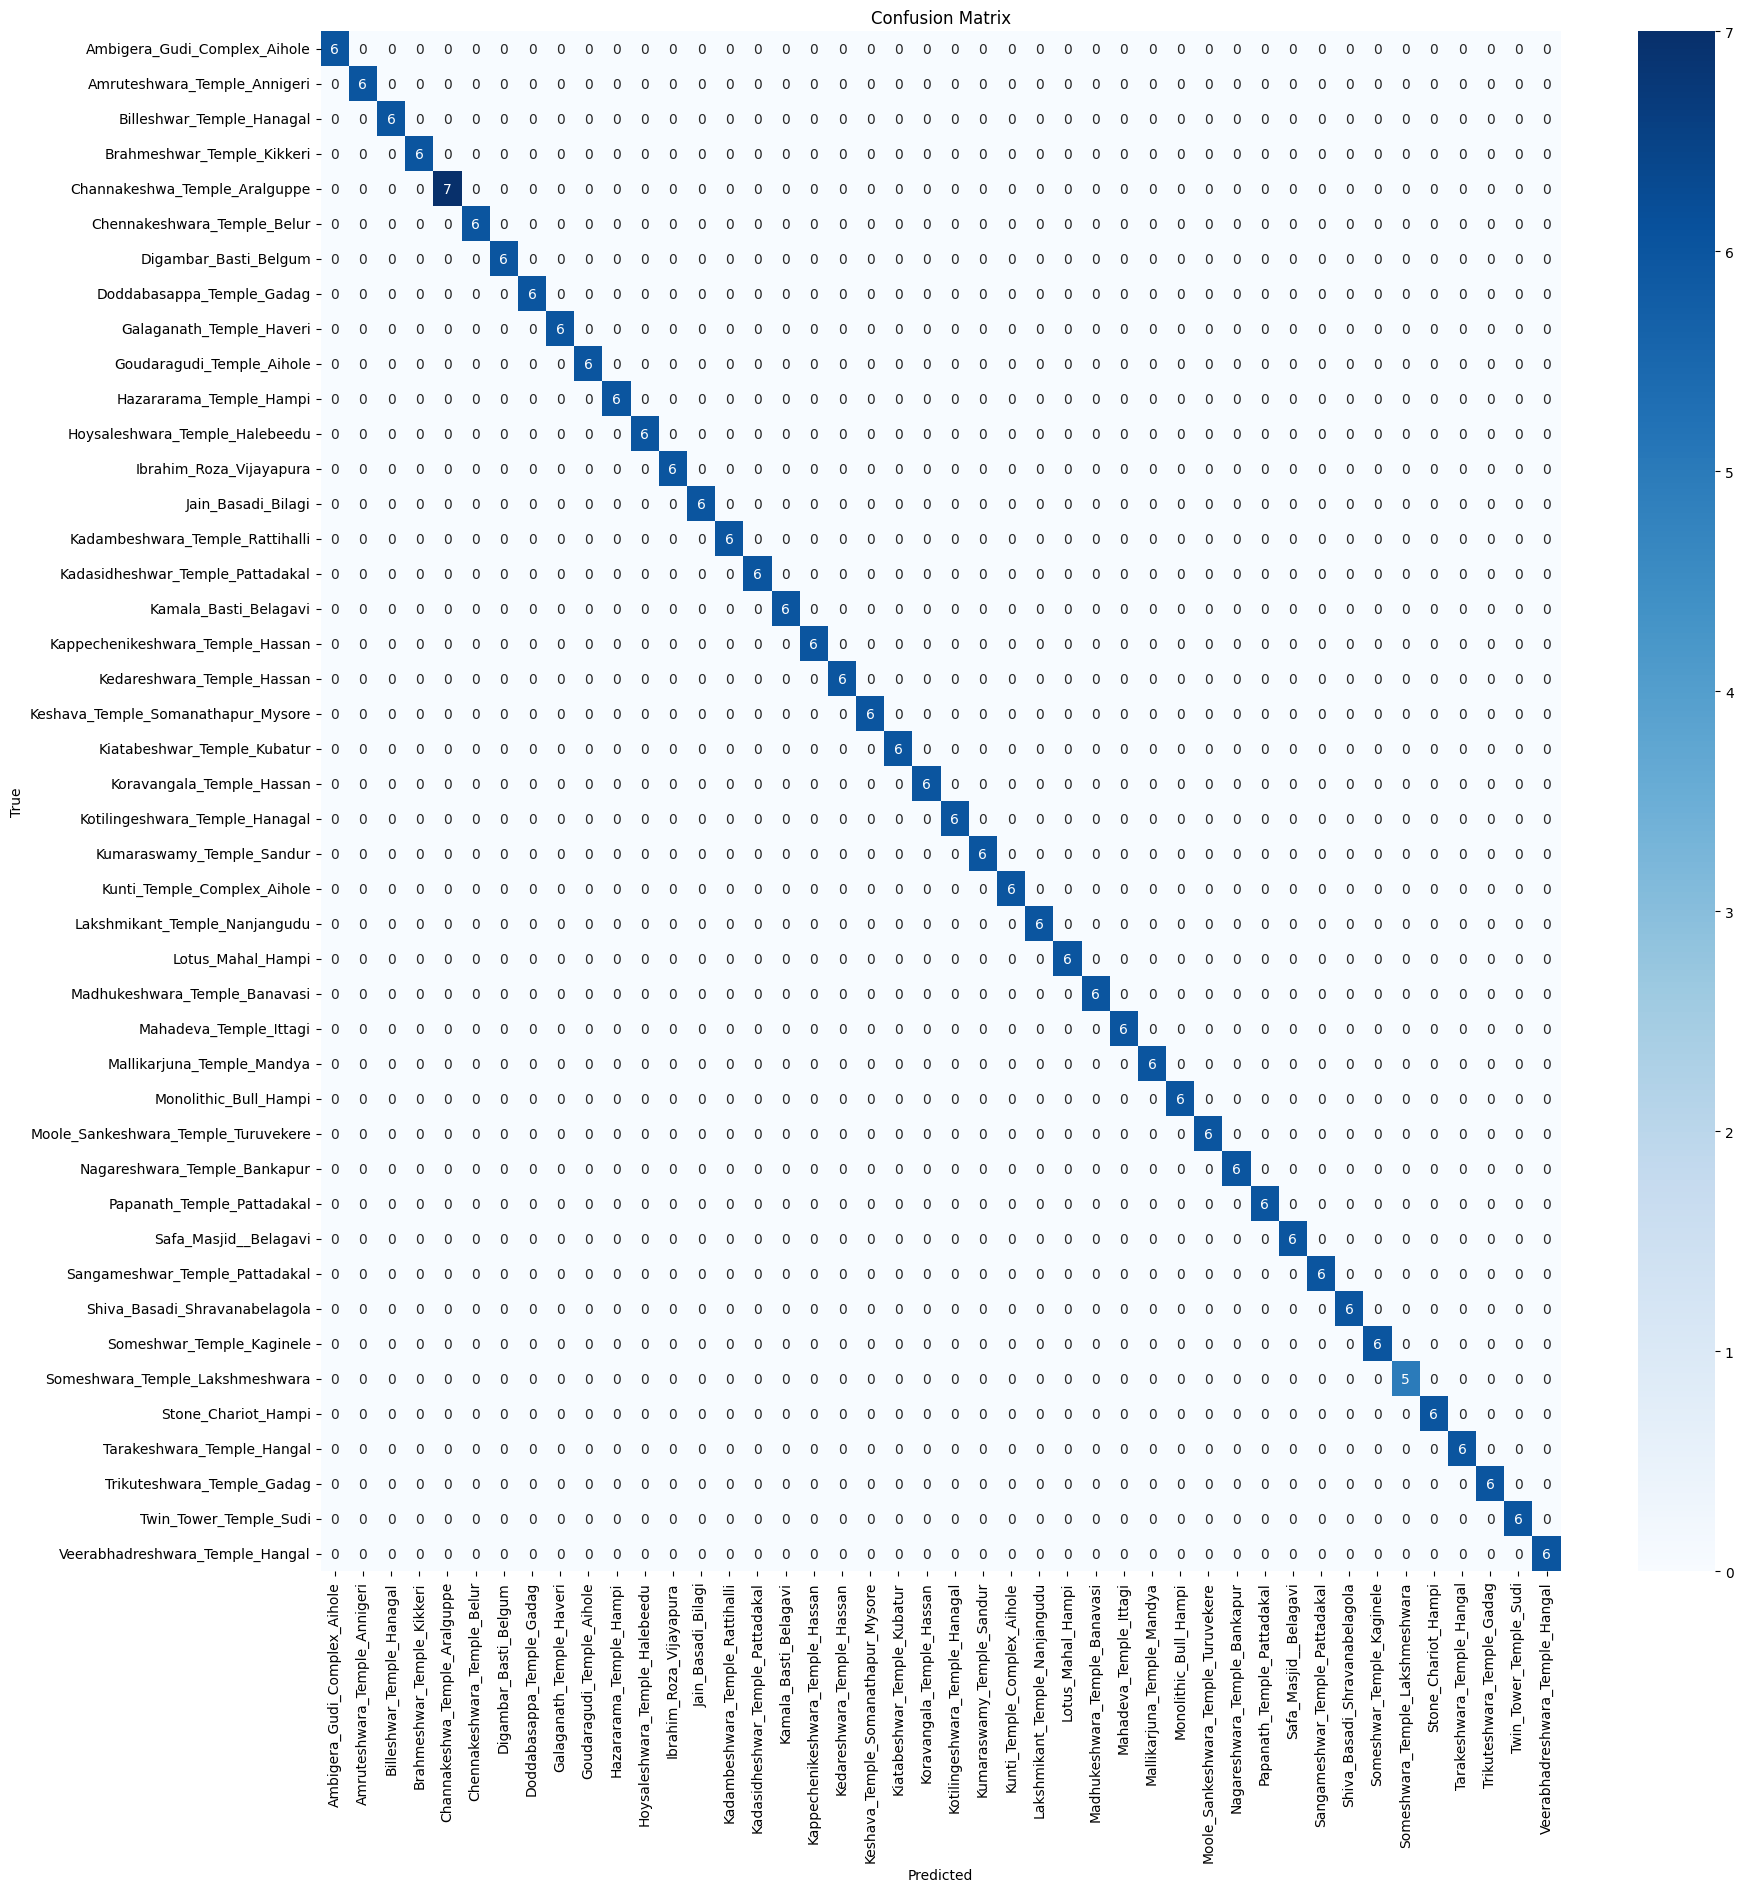

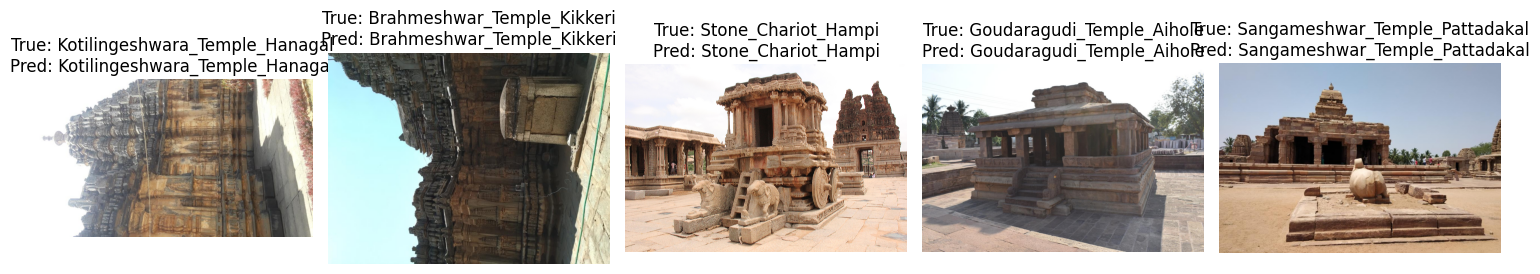

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Paths
dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"
output_dir = "/kaggle/working/"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset
class HeritageDataset(Dataset):
    def __init__(self, df, root_dir, processor):
        self.df = df
        self.root_dir = root_dir
        self.processor = processor
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(df["class_name"].unique()))}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]["image_path"])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            raise
        label = self.class_to_idx[self.df.iloc[idx]["class_name"]]
        encoding = self.processor(image, return_tensors="pt")
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        encoding["labels"] = torch.tensor(label, dtype=torch.long)
        encoding["image_path"] = img_path  # Store path for visualization
        return encoding

# Load and preprocess dataset split
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)  # Fix backslashes
test_df = df[df["split"] == "test"]
print(f"Test set size: {len(test_df)}")

# Validate paths
invalid_paths = []
for img_path in test_df["image_path"]:
    full_path = os.path.join(dataset_dir, img_path)
    if not os.path.exists(full_path):
        invalid_paths.append(full_path)
if invalid_paths:
    print(f"Invalid paths found: {invalid_paths[:5]}")
    raise FileNotFoundError("Fix invalid paths before proceeding")

# Load processor and model
processor = AutoImageProcessor.from_pretrained("/kaggle/working/best_cvt_13")
model = AutoModelForImageClassification.from_pretrained("/kaggle/working/best_cvt_13")
model.to(device)

# Create test dataset and loader
test_dataset = HeritageDataset(test_df, dataset_dir, processor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate model
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=pixel_values)
        test_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Compute metrics
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
class_names = [test_dataset.idx_to_class[i] for i in range(len(test_dataset.class_to_idx))]
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()

# Visualize predictions on 5 random test images
random_indices = random.sample(range(len(test_dataset)), 5)
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    sample = test_dataset[idx]
    img_path = sample["image_path"]
    image = Image.open(img_path).convert("RGB")
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
    true_label = test_dataset.idx_to_class[sample["labels"].item()]
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        pred_label = test_dataset.idx_to_class[outputs.logits.argmax(dim=1).cpu().numpy()[0]]
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.savefig("/kaggle/working/sample_predictions.png")
plt.show()

**pipeline for image classification and text generation**

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"
metadata_csv = "/kaggle/input/heritage-data-set/heritage_dataset/metadata.csv"

model = AutoModelForImageClassification.from_pretrained("/kaggle/input/cvt_13/other/default/1/kaggle/working/best_cvt_13")
processor = AutoImageProcessor.from_pretrained("/kaggle/input/cvt_13/other/default/1/kaggle/working/best_cvt_13")
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(df["class_name"].unique()))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
model.config.id2label = idx_to_class
classifier = pipeline("image-classification", model=model, image_processor=processor)

tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
metadata = pd.read_csv(metadata_csv)

def process_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None

    predictions = classifier(image)
    predicted_class = predictions[0]["label"]
    confidence = predictions[0]["score"]

    description = metadata[metadata["class_name"] == predicted_class]["description"].iloc[0]
    input_text = f"paraphrase: {description}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
    paraphrased = tokenizer.decode(outputs[0], skip_special_tokens=True)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.4f}")
    plt.axis("off")
    plt.show()

    return {
        "class": predicted_class,
        "confidence": confidence,
        "description": description,
        "paraphrased_description": paraphrased
    }

sample_image_path = "/kaggle/input/heritage-data-set/heritage_dataset/Ambigera_Gudi_Complex_Aihole/Ambigera_Gudi_Complex_Aihole_017.jpg"
result = process_image(sample_image_path)
if result:
    print(f"Class: {result['class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Description: {result['description']}")
    print(f"Paraphrased Description: {result['paraphrased_description']}")

with open("/kaggle/working/classification_pipeline.py", "w") as f:
    f.write("""from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from PIL import Image
import pandas as pd
import os

def process_image(image_path, model_path="/kaggle/working/best_cvt_13", metadata_path="/kaggle/input/heritage-data-set/heritage_dataset/metadata.csv"):
model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)
classifier = pipeline("image-classification", model=model, image_processor=processor)

tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

metadata = pd.read_csv(metadata_path)

try:
image = Image.open(image_path).convert("RGB")
except FileNotFoundError:
print(f"File not found: {image_path}")
return None

predictions = classifier(image)
predicted_class = predictions[0]["label"]
confidence = predictions[0]["score"]

description = metadata[metadata["class_name"] == predicted_class]["description"].iloc[0]

input_text = f"paraphrase: {description}"
inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
outputs = t5_model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
paraphrased = tokenizer.decode(outputs[0], skip_special_tokens=True)

return {
"class": predicted_class,
"confidence": confidence,
"description": description,
"paraphrased_description": paraphrased
}
""")

In [13]:
!pip install faiss-cpu transformers torch pandas pillow matplotlib numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizers parallelism warning

import faiss
import torch
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Paths
dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"
model_path = "/kaggle/working/best_cvt_13"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and processor
model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)
model.to(device)
model.eval()

# Load data
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)

# Function to compute embeddings
def get_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None
    inputs = processor(image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, output_hidden_states=True)
        embedding = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()  # Mean pooling
    return embedding

# Compute embeddings for all images
embeddings = []
valid_paths = []
for img_path in df["image_path"]:
    full_path = os.path.join(dataset_dir, img_path)
    embedding = get_embedding(full_path)
    if embedding is not None:
        embeddings.append(embedding)
        valid_paths.append(img_path)
embeddings = np.vstack(embeddings)

# Create FAISS index
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)

# Save index and paths
faiss.write_index(index, "/kaggle/working/heritage_image_index.index")
pd.DataFrame({"image_path": valid_paths}).to_csv("/kaggle/working/image_paths.csv", index=False)

# Query with a sample image
query_path = "/kaggle/input/heritage-data-set/heritage_dataset/Chennakeshwara_Temple_Belur/Chennakeshwara_Temple_Belur_1.jpg"
query_embedding = get_embedding(query_path)
k = 5
distances, indices = index.search(query_embedding, k)
print("Top 5 similar images:")
for idx, dist in zip(indices[0], distances[0]):
    similar_path = valid_paths[idx]
    similar_class = df[df["image_path"] == similar_path]["class_name"].iloc[0]
    print(f"Image: {similar_path}, Class: {similar_class}, Distance: {dist:.4f}")

# Visualize similar images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices[0]):
    img_path = os.path.join(dataset_dir, valid_paths[idx])
    image = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"Class: {df[df['image_path'] == valid_paths[idx]]['class_name'].iloc[0]}")
    plt.axis("off")
plt.tight_layout()
plt.savefig("/kaggle/working/similar_images_full.png")
plt.show()

Using device: cuda


ValueError: too many values to unpack (expected 2)

In [14]:
import pandas as pd
import os

# Paths
dataset_dir = "/kaggle/input/heritage-data-set/heritage_dataset"
split_csv = "/kaggle/input/heritage-data-set/heritage_dataset/dataset_split.csv"

# Load dataset
df = pd.read_csv(split_csv)
df["image_path"] = df["image_path"].str.replace(r'\\', '/', regex=True)  # Fix backslashes

# Check splits
train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]
test_df = df[df["split"] == "test"]
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# Check for duplicate image paths across splits
all_paths = df["image_path"].tolist()
duplicates = set([path for path in all_paths if all_paths.count(path) > 1])
print(f"Duplicate image paths: {duplicates}")

# Check for overlap between splits
train_paths = set(train_df["image_path"])
val_paths = set(val_df["image_path"])
test_paths = set(test_df["image_path"])
train_val_overlap = train_paths.intersection(val_paths)
train_test_overlap = train_paths.intersection(test_paths)
val_test_overlap = val_paths.intersection(test_paths)
print(f"Train-Val overlap: {train_val_overlap}")
print(f"Train-Test overlap: {train_test_overlap}")
print(f"Val-Test overlap: {val_test_overlap}")

# Check class balance
print("\nTest set class distribution:")
print(test_df["class_name"].value_counts())

Train size: 2108, Val size: 264, Test size: 264
Duplicate image paths: set()
Train-Val overlap: set()
Train-Test overlap: set()
Val-Test overlap: set()

Test set class distribution:
class_name
Channakeshwa_Temple_Aralguppe          7
Twin_Tower_Temple_Sudi                 6
Shiva_Basadi_Shravanabelagola          6
Koravangala_Temple_Hassan              6
Lakshmikant_Temple_Nanjangudu          6
Safa_Masjid__Belagavi                  6
Billeshwar_Temple_Hanagal              6
Doddabasappa_Temple_Gadag              6
Trikuteshwara_Temple_Gadag             6
Kotilingeshwara_Temple_Hanagal         6
Mahadeva_Temple_Ittagi                 6
Ibrahim_Roza_Vijayapura                6
Tarakeshwara_Temple_Hangal             6
Hazararama_Temple_Hampi                6
Chennakeshwara_Temple_Belur            6
Moole_Sankeshwara_Temple_Turuvekere    6
Kiatabeshwar_Temple_Kubatur            6
Sangameshwar_Temple_Pattadakal         6
Madhukeshwara_Temple_Banavasi          6
Papanath_Temple_Pattadakal  

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import accuracy\_score
import numpy as np

# Paths

dataset\_dir = "/kaggle/input/heritage-data-set/heritage\_dataset"
split\_csv = "/kaggle/input/heritage-data-set/heritage\_dataset/dataset\_split.csv"
output\_dir = "/kaggle/working/"
os.makedirs(output\_dir, exist\_ok=True)

# Device

device = torch.device("cuda" if torch.cuda.is\_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset

class HeritageDataset(Dataset):
def **init**(self, df, root\_dir, processor):
self.df = df
self.root\_dir = root\_dir
self.processor = processor
self.class\_to\_idx = {cls: idx for idx, cls in enumerate(sorted(df\["class\_name"].unique()))}

```
def __len__(self):
    return len(self.df)

def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.df.iloc[idx]["image_path"])
    try:
        image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        raise
    label = self.class_to_idx[self.df.iloc[idx]["class_name"]]
    encoding = self.processor(image, return_tensors="pt")
    encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
    encoding["labels"] = torch.tensor(label, dtype=torch.long)
    return encoding
```

# Load and preprocess dataset split

df = pd.read\_csv(split\_csv)
df\["image\_path"] = df\["image\_path"].str.replace(r'\\', '/', regex=True)  # Fix backslashes
train\_df = df\[df\["split"] == "train"]
val\_df = df\[df\["split"] == "val"]
test\_df = df\[df\["split"] == "test"]
print(f"Train: {len(train\_df)}, Val: {len(val\_df)}, Test: {len(test\_df)}")

# Validate paths

invalid\_paths = \[]
for img\_path in df\["image\_path"]:
full\_path = os.path.join(dataset\_dir, img\_path)
if not os.path.exists(full\_path):
invalid\_paths.append(full\_path)
if invalid\_paths:
print(f"Invalid paths found: {invalid\_paths\[:5]}")
raise FileNotFoundError("Fix invalid paths before proceeding")

# Load processor and model

processor = AutoImageProcessor.from\_pretrained("microsoft/cvt-13")
model = AutoModelForImageClassification.from\_pretrained(
"microsoft/cvt-13",
num\_labels=44,
ignore\_mismatched\_sizes=True
)
model.to(device)

# Create datasets

train\_dataset = HeritageDataset(train\_df, dataset\_dir, processor)
val\_dataset = HeritageDataset(val\_df, dataset\_dir, processor)
test\_dataset = HeritageDataset(test\_df, dataset\_dir, processor)

# DataLoaders

train\_loader = DataLoader(train\_dataset, batch\_size=32, shuffle=True, num\_workers=4)
val\_loader = DataLoader(val\_dataset, batch\_size=32, shuffle=False, num\_workers=4)
test\_loader = DataLoader(test\_dataset, batch\_size=32, shuffle=False, num\_workers=4)

# Training setup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight\_decay=0.01)
scheduler = torch.optim.lr\_scheduler.CosineAnnealingLR(optimizer, T\_max=10)
num\_epochs = 50
best\_val\_acc = 0.0

# Training loop

for epoch in range(num\_epochs):
model.train()
train\_loss, train\_preds, train\_labels = 0.0, \[], \[]
for batch in train\_loader:
pixel\_values = batch\["pixel\_values"].to(device)
labels = batch\["labels"].to(device)
optimizer.zero\_grad()
outputs = model(pixel\_values=pixel\_values, labels=labels)
loss = outputs.loss
loss.backward()
optimizer.step()
train\_loss += loss.item()
train\_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
train\_labels.extend(labels.cpu().numpy())
train\_acc = accuracy\_score(train\_labels, train\_preds)

```
model.eval()
val_loss, val_preds, val_labels = 0.0, [], []
with torch.no_grad():
    for batch in val_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        val_loss += loss.item()
        val_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
val_acc = accuracy_score(val_labels, val_preds)

if val_acc > best_val_acc:
    best_val_acc = val_acc
    model.save_pretrained(os.path.join(output_dir, "best_cvt_13"))
    processor.save_pretrained(os.path.join(output_dir, "best_cvt_13"))

print(f"Epoch {epoch+1}/{num_epochs}: "
      f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
      f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

scheduler.step()
```

# Test evaluation

model = AutoModelForImageClassification.from\_pretrained(os.path.join(output\_dir, "best\_cvt\_13"))
model.to(device)
model.eval()
test\_preds, test\_labels = \[], \[]
with torch.no\_grad():
for batch in test\_loader:
pixel\_values = batch\["pixel\_values"].to(device)
labels = batch\["labels"].to(device)
outputs = model(pixel\_values=pixel\_values)
test\_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
test\_labels.extend(labels.cpu().numpy())
test\_acc = accuracy\_score(test\_labels, test\_preds)
print(f"Test Accuracy: {test\_acc:.4f}")

# Save final model

model.save\_pretrained(os.path.join(output\_dir, "final\_cvt\_13"))
processor.save\_pretrained(os.path.join(output\_dir, "final\_cvt\_13"))
